This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
# All system imports
import time
import clocks
import fitsio

import numpy as np
import scipy
import scipy.optimize as opt

import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
# FEE connection and initialization.
# Initialize everything to some sane state.
import fee.feeControl as feeMod
reload(feeMod)

doLoad = False
doCalib = False

fee = feeMod.FeeControl(logLevel=20)
if doLoad:
    fee.sendImage('/home/pfs/feeMain.hex')
else:
    fee.powerUp()
    time.sleep(1)

if doCalib:
    fee.raw('c7,CDS')
    fee.raw('c7,bias')


FEE revision: PFS BEE Rev 20150529-01, copyright JHU
FEE serial: 306052
SUCCESS
SUCCESS
SUCCESS


In [14]:
%pdb off

fee.zeroOffsets()
fee.setOffsets(np.arange(8), [-20]*8, leg='p')
#print fee.raw('sb,Sp,ch1,0.0')
#print fee.raw('sb,Sn,ch1,4.0')

#fee.doSet('offset', '0p', 10, channel=0) 

Automatic pdb calling has been turned OFF


In [16]:
fee.raw('lp,BT1')

'SUCCESS'

In [17]:

for t in 'voltage',:
    for v in fee.allKeys(t):
        print("%s %s = %s" % (t, v, fee.doGet(t, v)))

print

for t in 'offset','bias':
    for ch in 0,1:
        for v in fee.allKeys(t):       
            print("%s %s,%d = %s" % (t, v, ch, fee.doGet(t, v, ch)))
        print
    print


voltage 3V3M = 3.30
voltage 3V3 = 3.29
voltage 5VP = 4.97
voltage 5VN = -4.89
voltage 5VPpa = 4.99
voltage 5VNpa = -4.91
voltage 12VP = 11.62
voltage 12VN = -11.53
voltage 24VN = -23.07
voltage 54VP = 49.44

offset 0p,0 = -20.02
offset 1p,0 = -20.02
offset 2p,0 = -20.00
offset 3p,0 = -19.99
offset 0n,0 = 0.03
offset 1n,0 = 0.04
offset 2n,0 = 0.05
offset 3n,0 = 0.06

offset 0p,1 = -20.13
offset 1p,1 = -20.15
offset 2p,1 = -20.13
offset 3p,1 = -20.11
offset 0n,1 = -0.02
offset 1n,1 = -0.03
offset 2n,1 = -0.01
offset 3n,1 = 0.00


bias Pp,0 = 0.00
bias Pn,0 = 0.00
bias DGp,0 = 0.00
bias DGn,0 = 0.00
bias Sp,0 = 0.00
bias Sn,0 = 0.00
bias SWp,0 = 0.00
bias SWn,0 = 0.00
bias RGp,0 = 0.00
bias RGn,0 = 0.00
bias OG,0 = 0.00
bias RD,0 = -0.66
bias OD,0 = -0.69
bias BB,0 = 0.00

bias Pp,1 = 0.00
bias Pn,1 = 0.00
bias DGp,1 = 0.00
bias DGn,1 = 0.00
bias Sp,1 = 0.00
bias Sn,1 = 0.00
bias SWp,1 = 0.00
bias SWn,1 = 0.00
bias RGp,1 = 0.00
bias RGn,1 = 0.00
bias OG,1 = 0.00
bias RD,1 = -0.66
bias OD,

In [18]:
# FPGA connection and initialization.
# All the reloads are to make sure that new code gets picked up
import fpga as fpgaMod
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD(adc18bit=1)  # adc18bit=2 reads the low bits.
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeefa070


In [19]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks_001
import clocks_002
import clocks
reload(clocks_001)
reload(clocks_002)
reload(clocks)

pfsClocks = clocks_002.standardClocks
pre, pix, post = pfsClocks()


0100 65346.1 65322.6 65314.7 65356.5 65288.8 65314.3 65313.1 65360.3 0.70 0.78 0.67 0.84 3.61 3.61 3.39 3.48 OK
0199 65346.2 65322.5 65314.8 65356.5 65288.7 65314.1 65313.1 65360.2 0.69 0.72 0.69 0.89 3.53 3.63 3.39 3.47 OK
0100 65346.1 65322.6 65314.9 65356.4 65289.0 65314.5 65313.2 65360.3 0.71 0.73 0.73 0.90 3.55 3.55 3.32 3.43 OK
0199 65346.1 65322.6 65314.8 65356.4 65289.1 65314.6 65313.4 65360.5 0.70 0.76 0.68 0.86 3.60 3.63 3.43 3.52 OK
!!!! unwraping 857600 pixels !!!!
means(0.000): [-188.9127 -212.4076 -220.2050 -178.5710 -246.0480 -220.4939 -221.7646 -174.6326]
devs (0.000): [0.6986 0.7039 0.7047 0.6908 3.5212 3.5635 3.3510 3.4346]

0100 2597.4 2579.8 2578.3 2621.8 2548.4 2568.7 2554.3 2617.6 0.70 0.79 0.72 0.92 3.74 3.67 3.51 3.53 OK
0199 2597.3 2579.8 2578.4 2621.8 2549.0 2569.0 2554.8 2618.1 0.72 0.76 0.72 0.89 3.74 3.60 3.40 3.53 OK
!!!! unwraping 8 pixels !!!!
means(39.800): [2597.3123 2579.8237 2578.3852 2621.6874 2548.6459 2568.6882 2554.3621 2617.6404]
devs (39.800): 

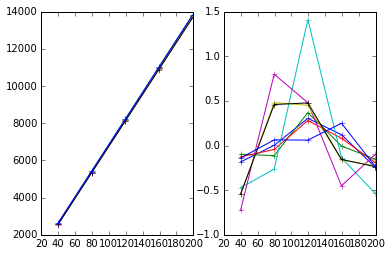

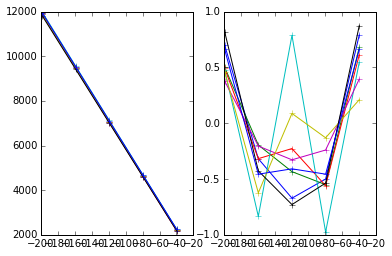

In [131]:
reload(nbFuncs)
fee.zeroOffsets()
doGainCurve = True
if doGainCurve:
    stepSize = 19.9*2
    statCols = slice(5,None)
    amps = np.arange(8)
    noffsets, nlevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=stepSize, leg='n', 
                                          statCols=statCols, doUnwrap=65000)
    poffsets, plevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=-stepSize, leg='p', 
                                          statCols=statCols, doUnwrap=65000)
    
    print
    nfits = nbFuncs.plotGains(noffsets, nlevels, amps=amps)
    print
    pfits = nbFuncs.plotGains(poffsets, plevels, amps=amps)

In [113]:
nlev = np.array(nlevels)
noff = np.array(noffsets).reshape(len(noffsets),1)
nn = np.hstack((noff,nlev))
np.savetxt('noff.txt', nn, delimiter=',',fmt="%0.3f")
print nfits
#np.savetxt('poff.txt', pp, delimiter=',',fmt="%0.3f")

[[  78755.6117975   -15008.63011048]
 [-418565.33061931   63390.12769617]
 [-234428.02543219   57296.27434589]
 [  79150.18038317   20808.15375895]]


In [247]:
# Run this to take the current N- offsets, and apply half to N- and half to N+ (opposite sign)
#fee.zeroLevels(leg='p')
fee.zeroLevels()
#fee.setLevels(range(8), [0.05]*8, leg='n')
#fee.setLevels(range(8), [0.014]*8, leg='n')
fee.setLevels(range(8), [-0.02]*8, leg='p')
#fee.setLevels(range(8), [-0.02]*8, leg='p')
#fee.setLevels(range(8), [-0.02]*8, leg='p')

baseOffs = dict(zip(goodAmps, offs))
print baseOffs

{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.060313427795240938, 5: 0.15486973631988396, 6: 0.077996960811883148, 7: 0.16784309643486645}


In [119]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

allAmps = np.arange(8)
badAmps = []

dummyCcd = False
if not dummyCcd:
    goodAmps = np.arange(8)

    startStep = 0.02
    levels = 1000
else:
    goodAmps = np.arange(4) + 4
    
    startStep = 0.02
    levels = np.zeros(8)
    levels[4:] = [10000,25000,20000,15000]

ncols=300

doTune = True
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=levels, adjOffset=5, 
                                           amps=goodAmps,
                                           statCols=slice(2,None), 
                                           maxLoops=10, nrows=200, 
                                           startStep=startStep, 
                                           startOffset=startStep,
                                           sigTol=4, 
                                           clockFunc=pfsClocks, 
                                           legs='p', # useGains=nfits[:,0], 
                                           doZero=True, doUnwrap=64000)

    defOffsets = offs
else:
    #defOffsets = np.array([0.014]*8) # np.array([0.0151, 0.0143, 0.0147, 0.0152, 0.0142, 0.0154, 0.0141, 0.0146])
    defOffsets = np.array([0.0188, 0.0189, 0.0426, 0.0424, 0.0193, 0.0193, 0.0433, 0.0402])
    offs = defOffsets
    fee.zeroLevels()
    fee.setLevels(range(8), defOffsets)

Automatic pdb calling has been turned OFF


KeyboardInterrupt: 

In [88]:
print fee.raw('sb,Sp,ch1,0.0')
print fee.raw('sb,Sn,ch1,4.0')

SUCCESS
SUCCESS


means: [1062.872 1074.442 1050.772 1070.936 1061.569 1039.659 1047.485 1056.999]
devs:  [0.728 0.699 0.712 0.714 4.163 4.133 4.044 4.105]
peak:  1039.0 1026 1051 12.0
file: /data/pfs/2015-06-02/PFSA-00000954.fits


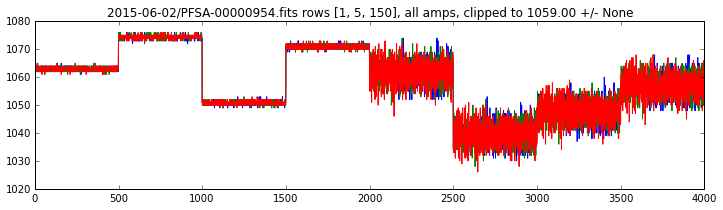

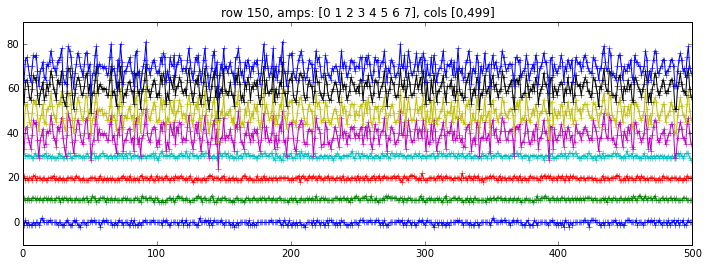

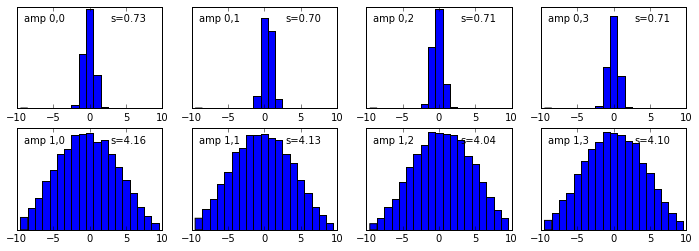

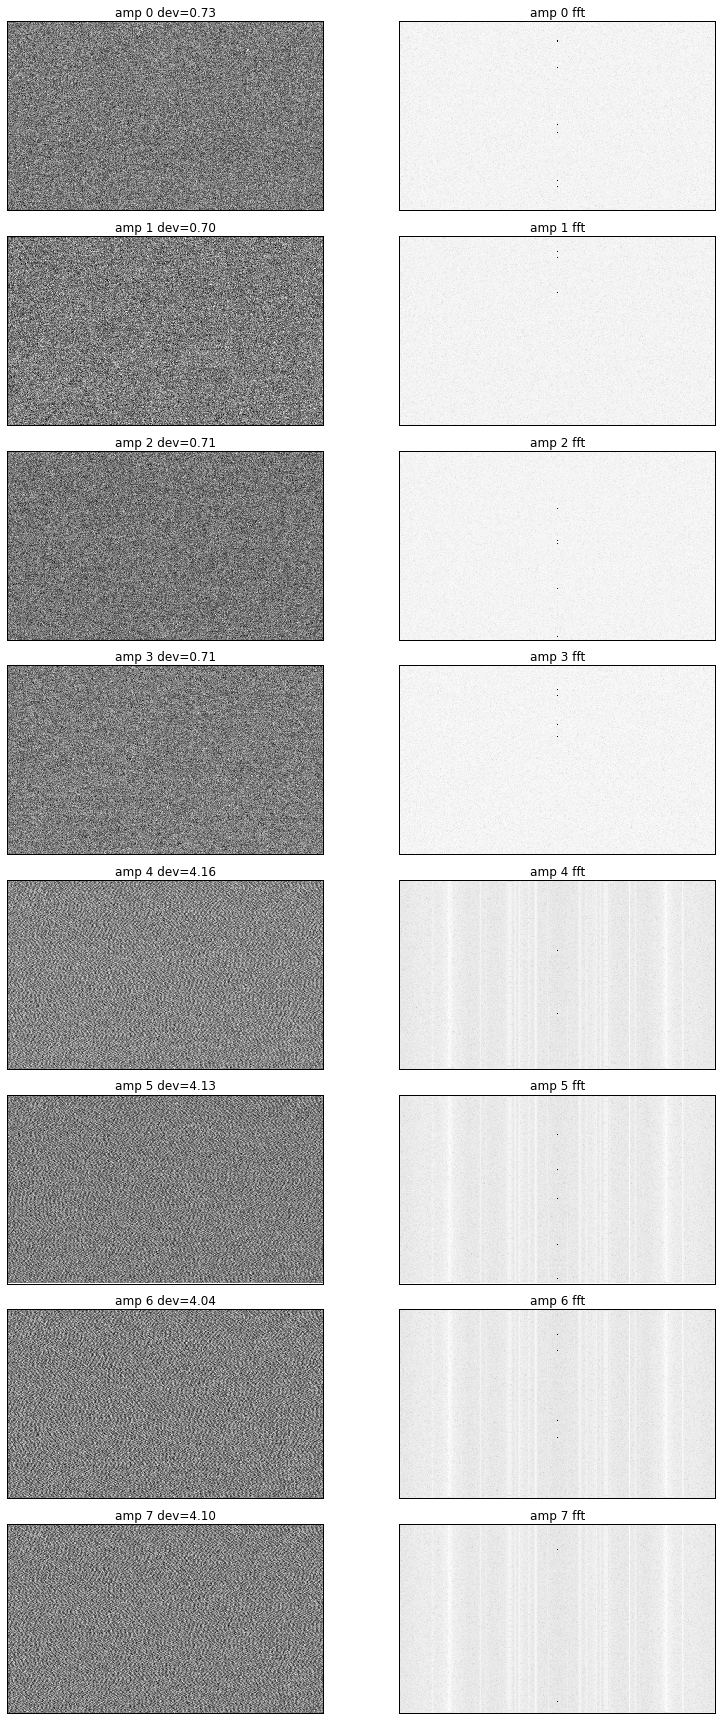

In [26]:
reload(ccdFuncs)
reload(nbFuncs)

reload(clocks_002)
reload(clocks)
pfsClocks = clocks_002.standardClocks

goodAmps = np.arange(8) #[3,4,5,6, 7] # np.arange(8)
badAmps = []

# fee.raw('sb,SWn,ch1,0.0')

nrows = 300                # How many rows to read out.
ncols = 500
selectRows = None #slice(5,None)
selectCols = None # slice(5,5)
pcols = np.arange(0,ncols)    # Which cols to plot
statCols = np.arange(10,ncols) # Which cols to use for stats
prow = (nrows+1)/2
prows = [1, 5, prow]       # which rows to plot
fftAmps = []

figWidth = 12

argDict = dict(everyNRows=500, ampList=goodAmps, cols=statCols, ccd=ccd)

doFile = '/data/pfs/2015-06-02/PFSA-00000954.fits'
if doFile:
    im = fitsio.read(doFile)
else:
    im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                              rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                              clockFunc=pfsClocks, doSave=True)
if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
hi_w = np.where(im > 65500)
im[hi_w] -= 65535
amp4Mask = ccd.ampidx(5, im)
#amp6Mask = ccd.ampidx(6, im)
#im[:, amp6Mask] -= im[:, amp6Mask].mean()
#im[:, amp6Mask] += im[:, ccd.ampidx(4, im)].mean()

means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

print "peak: ", med4, min4, max4, max4-med4

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=None)

# plot one row for each the "good" amps
f = plt.figure('plotAmps')
peaks = None # np.arange(1, ncols, 50)
nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                 plotOffset=10, fig=f, figWidth=figWidth, peaks=peaks)

# f.axes[0].set_ylim(-50, 150)

# plot any bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, figWidth=figWidth)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=pcols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=pcols, figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()

[ 129000.          129300.          129000.          129000.
  128888.88888889]
[ 62000.          62000.          62000.          62000.          61285.71428571
  43200.          36083.33333333]
[ 146000.          146000.          145666.66666667  145750.
  145714.28571429]


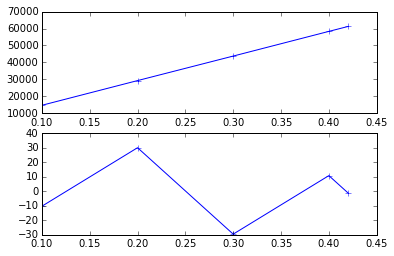

In [241]:
#v = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.2, 1.7]
#f = [2800, 5500, 8400, 9700, 10800, 11900, 12900, 13900, 14900, 15900, 18900, 23600]

#v = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.8])
#f = np.array([5500, 11000, 16500, 22000, 27400, 38200, 40000])

v = np.array([0.1, 0.2, 0.3, 0.4, 0.45])
f = np.array([12900, 25860, 38700, 51600, 58000])
print f/v

v = np.array([0.1, 0.2, 0.5, 0.6, 0.7, 1.0, 1.2])
f = np.array([6200, 12400, 31000, 37200, 42900, 43200, 43300])
print f/v


v = np.array([0.1, 0.2, 0.3, 0.4, 0.42])
f = np.array([14600, 29200, 43700, 58300, 61200])
fit = np.polyfit(v, f, 1)
ev = np.polyval(fit, v)                                                                                              
_f, plots = plt.subplots(nrows=2, ncols=1)
plots[0].plot(v,f, '+-')
plots[1].plot(v, f-ev, '+-')                                                                                         

print f/v



0: 00012160 00019533
1: 00004723 00019976
2: 00035832 00019915
3: 00039979 00015307
4: 00000022 00006392
5: 00040000 00005731
6: 00000000 00005723
7: 00000000 00034277
8: 00040000 00040000
9: 00040000 00000000
10: 00040000 00040000
11: 00000000 00040000
12: 00000000 00000000
13: 00000000 00000000
14: 00000000 00000000
15: 00000000 00000000


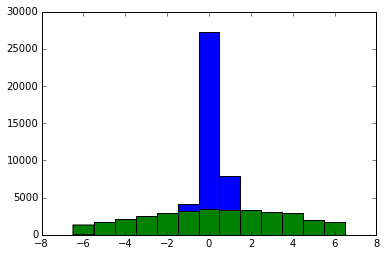

In [152]:
a0 = im[:,ccd.ampidx(0, im)]
a2 = im[:,ccd.ampidx(4, im)]

plt.hist(a0.flat - np.median(a0.flat), bins=np.arange(14)-6.5)
plt.hist(a2.flat - np.median(a2.flat), bins=np.arange(14)-6.5)

for i in range(16):
    print "%d: %08d %08d" % (i, ((a0 & (1<<i)) > 0).sum(), ((a2 & (1<<i)) > 0).sum()) 

#plt.figure()
#plt.imshow(a0)
#plt.plot(np.where(a0 & 0x1),'.')
#yy,xx = np.where(a0 & 0x1)
#print np.unique(xx)
